In [3]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import shutil
from sklearn.preprocessing import LabelEncoder
import random
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.utils import image_dataset_from_directory

from keras.applications import ResNet50
import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from PIL import Image
from glob import glob
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [7]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma'
}
metadata_path = "C:/Users/Brando/Desktop/dataverse_files/HAM10000_metadata.csv"
metadata_df = pd.read_csv(metadata_path)

In [10]:
base_skin_dir = "C:/Users/Brando/Desktop/dataverse_files/"

image_paths = {os.path.splitext(os.path.basename(x))[0]: x
               for x in glob(os.path.join(base_skin_dir, 'HAM10000_images_part_*', '*.jpg'), recursive=True)}

metadata_df['path'] = metadata_df['image_id'].map(image_paths.get)
metadata_df = metadata_df[metadata_df['dx'].isin(['nv', 'mel'])]
metadata_df['cell_type'] = metadata_df['dx'].map(lesion_type_dict.get)
metadata_df['cell_type_idx'] = pd.Categorical(metadata_df['cell_type']).codes

metadata_df.sample(5)


lesion_id      image_id   dx    dx_type   age     sex  \
1317  HAM_0006692  ISIC_0029163  mel      histo  80.0    male   
5131  HAM_0000605  ISIC_0030212   nv  follow_up  45.0  female   
3450  HAM_0003233  ISIC_0031571   nv  follow_up  40.0  female   
4252  HAM_0006212  ISIC_0029721   nv  follow_up  70.0    male   
7908  HAM_0005052  ISIC_0033786   nv      histo  35.0    male   

         localization                                               path  \
1317            scalp  C:/Users/Brando/Desktop/dataverse_files\HAM100...   
5131             foot  C:/Users/Brando/Desktop/dataverse_files\HAM100...   
3450            trunk  C:/Users/Brando/Desktop/dataverse_files\HAM100...   
4252            trunk  C:/Users/Brando/Desktop/dataverse_files\HAM100...   
7908  lower extremity  C:/Users/Brando/Desktop/dataverse_files\HAM100...   

             cell_type  cell_type_idx  
1317          Melanoma              1  
5131  Melanocytic nevi              0  
3450  Melanocytic nevi              0  
4252  Melanocytic nevi              0  
7908  Melanocytic nevi              0

In [11]:
metadata_df.head()

lesion_id      image_id   dx    dx_type   age     sex  \
64    HAM_0001751  ISIC_0024698   nv  consensus  70.0    male   
1210  HAM_0000559  ISIC_0024693   nv  follow_up  45.0  female   
1211  HAM_0000871  ISIC_0025964  mel      histo  40.0  female   
1212  HAM_0000871  ISIC_0030623  mel      histo  40.0  female   
1213  HAM_0000040  ISIC_0027190  mel      histo  80.0    male   

         localization                                               path  \
64               face  C:/Users/Brando/Desktop/dataverse_files\HAM100...   
1210  upper extremity  C:/Users/Brando/Desktop/dataverse_files\HAM100...   
1211            chest  C:/Users/Brando/Desktop/dataverse_files\HAM100...   
1212            chest  C:/Users/Brando/Desktop/dataverse_files\HAM100...   
1213  upper extremity  C:/Users/Brando/Desktop/dataverse_files\HAM100...   

             cell_type  cell_type_idx  
64    Melanocytic nevi              0  
1210  Melanocytic nevi              0  
1211          Melanoma              1  
1212          Melanoma              1  
1213          Melanoma              1

In [12]:
metadata_df.isnull().sum()

lesion_id         0
image_id          0
dx                0
dx_type           0
age              47
sex               0
localization      0
path              0
cell_type         0
cell_type_idx     0
dtype: int64

In [15]:
metadata_df['age'].fillna(metadata_df['age'].mean(), inplace=True)
metadata_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age              0
sex              0
localization     0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

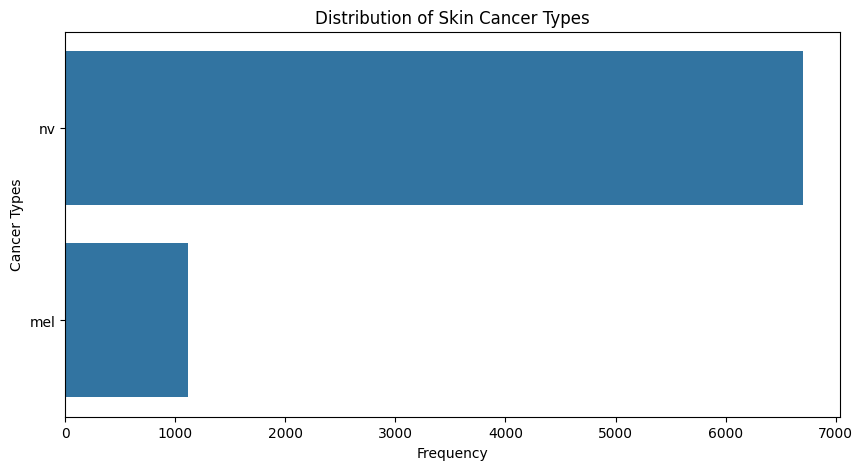

In [16]:
plt.figure(figsize=(10, 5))
sns.countplot(y=metadata_df['dx'], order = metadata_df['dx'].value_counts().index)
plt.title('Distribution of Skin Cancer Types')
plt.xlabel('Frequency')
plt.ylabel('Cancer Types')
plt.show()

<Axes: xlabel='localization'>

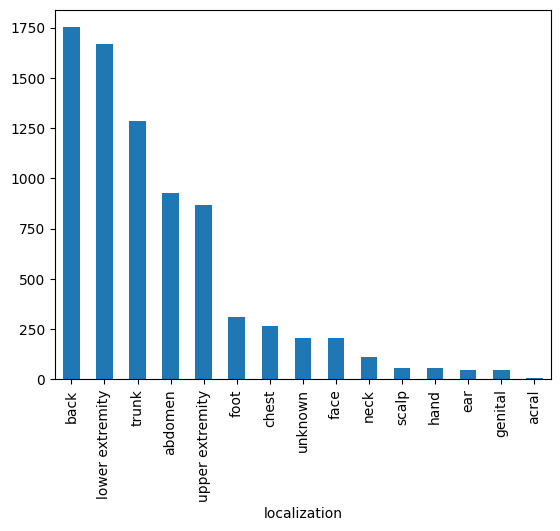

In [17]:
metadata_df['localization'].value_counts().plot(kind='bar')

<Axes: xlabel='age'>

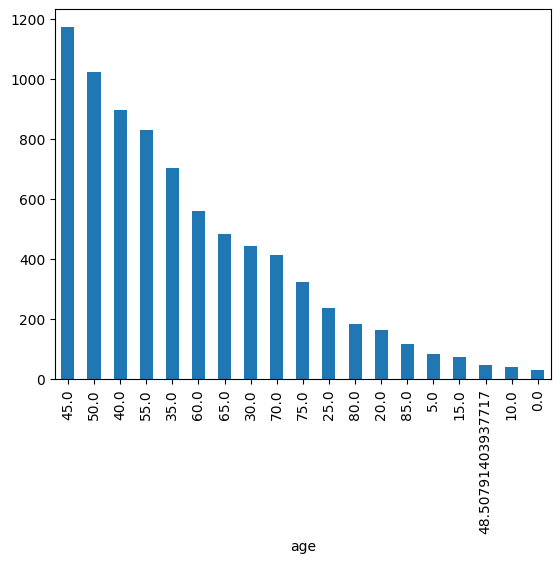

In [18]:
metadata_df['age'].value_counts().plot(kind='bar')

<Axes: xlabel='sex'>

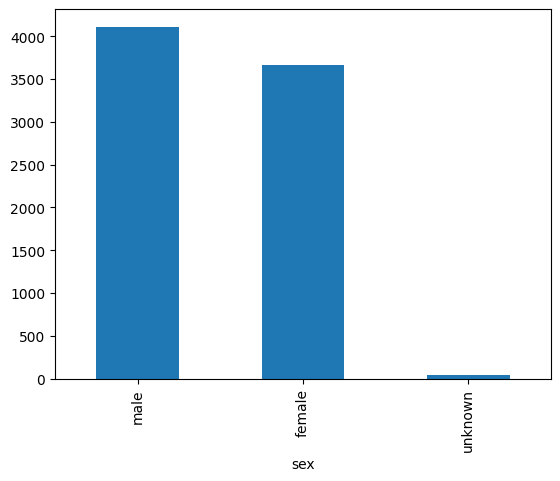

In [19]:
metadata_df['sex'].value_counts().plot(kind='bar')

In [20]:
print("Unique Cancer types represented in data.")
print(metadata_df.dx.unique(),"\n")

encoder = LabelEncoder()
metadata_df["dx_label"] = encoder.fit_transform(metadata_df["dx"])

print("Cancer types and their integer encoding")
print(encoder.classes_)
print(encoder.transform(encoder.classes_))

Unique Cancer types represented in data.
['nv' 'mel'] 

Cancer types and their integer encoding
['mel' 'nv']
[0 1]


In [28]:
images_dir_1 = r"C:\Users\Brando\Desktop\dataverse_files\HAM10000_images_part_1"
images_dir_2 = r"C:\Users\Brando\Desktop\dataverse_files\HAM10000_images_part_2"

train_images_dir = r"C:\Users\Brando\Desktop\dataverse_files\train_image"

dir_names = metadata_df['dx_label'].unique()
os.makedirs(train_images_dir, exist_ok=True)

def create_dirs(dir_path, dir_names):
    for dir_name in dir_names:
        try:
            os.makedirs(os.path.join(dir_path, str(dir_name)))
        except FileExistsError:
            continue

create_dirs(train_images_dir, dir_names)

def move_images(src_dirs, dest_dir, metadata_df):
    for src_dir in src_dirs:
        for image in os.scandir(src_dir):
            try:
                img_name = image.name.split(".")[0]
                img_cancer_type = str(metadata_df.dx_label[metadata_df.image_id == img_name].item())
                shutil.copy(os.path.join(src_dir, image.name), os.path.join(dest_dir, img_cancer_type, image.name))
            except Exception as e:
                print(f"Error con la imagen {image.name}: {e}")

image_dirs = [images_dir_1, images_dir_2]

move_images(image_dirs, train_images_dir, metadata_df)

Error con la imagen ISIC_0024312.jpg: can only convert an array of size 1 to a Python scalar
Error con la imagen ISIC_0024318.jpg: can only convert an array of size 1 to a Python scalar
Error con la imagen ISIC_0024324.jpg: can only convert an array of size 1 to a Python scalar
Error con la imagen ISIC_0024329.jpg: can only convert an array of size 1 to a Python scalar
Error con la imagen ISIC_0024330.jpg: can only convert an array of size 1 to a Python scalar
Error con la imagen ISIC_0024331.jpg: can only convert an array of size 1 to a Python scalar
Error con la imagen ISIC_0024332.jpg: can only convert an array of size 1 to a Python scalar
Error con la imagen ISIC_0024336.jpg: can only convert an array of size 1 to a Python scalar
Error con la imagen ISIC_0024337.jpg: can only convert an array of size 1 to a Python scalar
Error con la imagen ISIC_0024338.jpg: can only convert an array of size 1 to a Python scalar
Error con la imagen ISIC_0024345.jpg: can only convert an array of siz

In [29]:
print(metadata_df.columns)

Index(['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization',
       'path', 'cell_type', 'cell_type_idx', 'dx_label'],
      dtype='object')


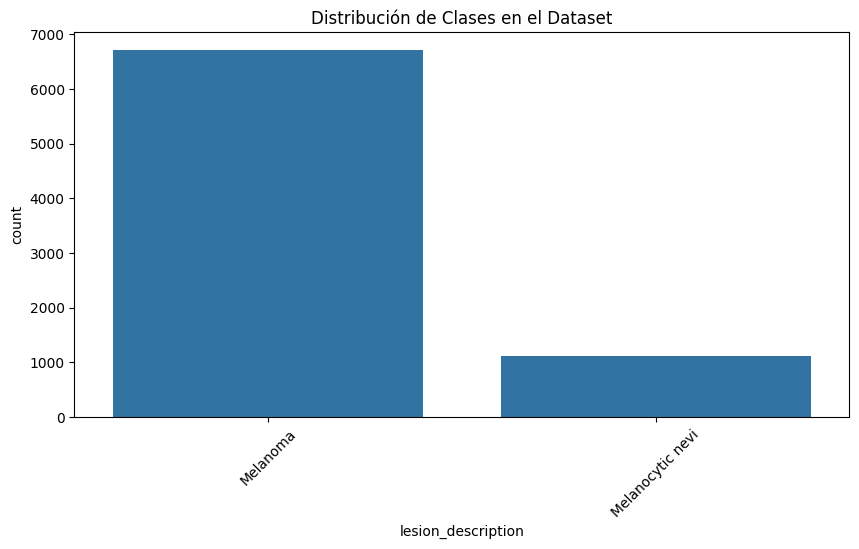

In [30]:
label_dict = label_dict = {
    1: 'mel',
    0: 'nv'
}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma'
}

metadata_df['lesion_abbr'] = metadata_df['dx_label'].map(label_dict)
metadata_df['lesion_description'] = metadata_df['lesion_abbr'].map(lesion_type_dict)

fig, ax = plt.subplots(figsize=(10, 5))
sns.countplot(x='lesion_description', data=metadata_df, ax=ax)
ax.set_title('Distribución de Clases en el Dataset')
plt.xticks(rotation=45)
plt.show()

In [36]:
train_images_dir = r"C:\Users\Brando\Desktop\dataverse_files\train_image"
test_images_dir = r"C:\Users\Brando\Desktop\dataverse_files\validation"

dir_names = ['0', '1']

encoder = LabelEncoder()
encoder.fit(dir_names) 

inds = [] 
twenty_percent_content = {}

for dir_name in os.scandir(train_images_dir):
    if dir_name.is_dir():
        for cancer_img in os.scandir(dir_name):
            if cancer_img.is_file():
                inds.append(cancer_img.path.split(os.sep)[-2])

for directory in dir_names:
    total_amt = inds.count(str(directory))
    print(f"There are {total_amt} images of category {directory}.")
    print(f"20% of category {directory} images is: {round(total_amt * 0.20)}\n")
    twenty_percent_content[directory] = round(total_amt * 0.20)

for dir_name in dir_names:
    os.makedirs(os.path.join(test_images_dir, dir_name), exist_ok=True)

for sub_dir in os.scandir(train_images_dir):
    if sub_dir.is_dir() and sub_dir.name in dir_names:
        images_paths = [image.path for image in os.scandir(sub_dir.path) if image.is_file()]
        for image_path in images_paths[:int(twenty_percent_content[sub_dir.name])]:
            dest_path = os.path.join(test_images_dir, sub_dir.name, os.path.basename(image_path))
            shutil.move(image_path, dest_path)

There are 890 images of category 0.
20% of category 0 images is: 178

There are 5364 images of category 1.
20% of category 1 images is: 1073



Total de muestras: 20


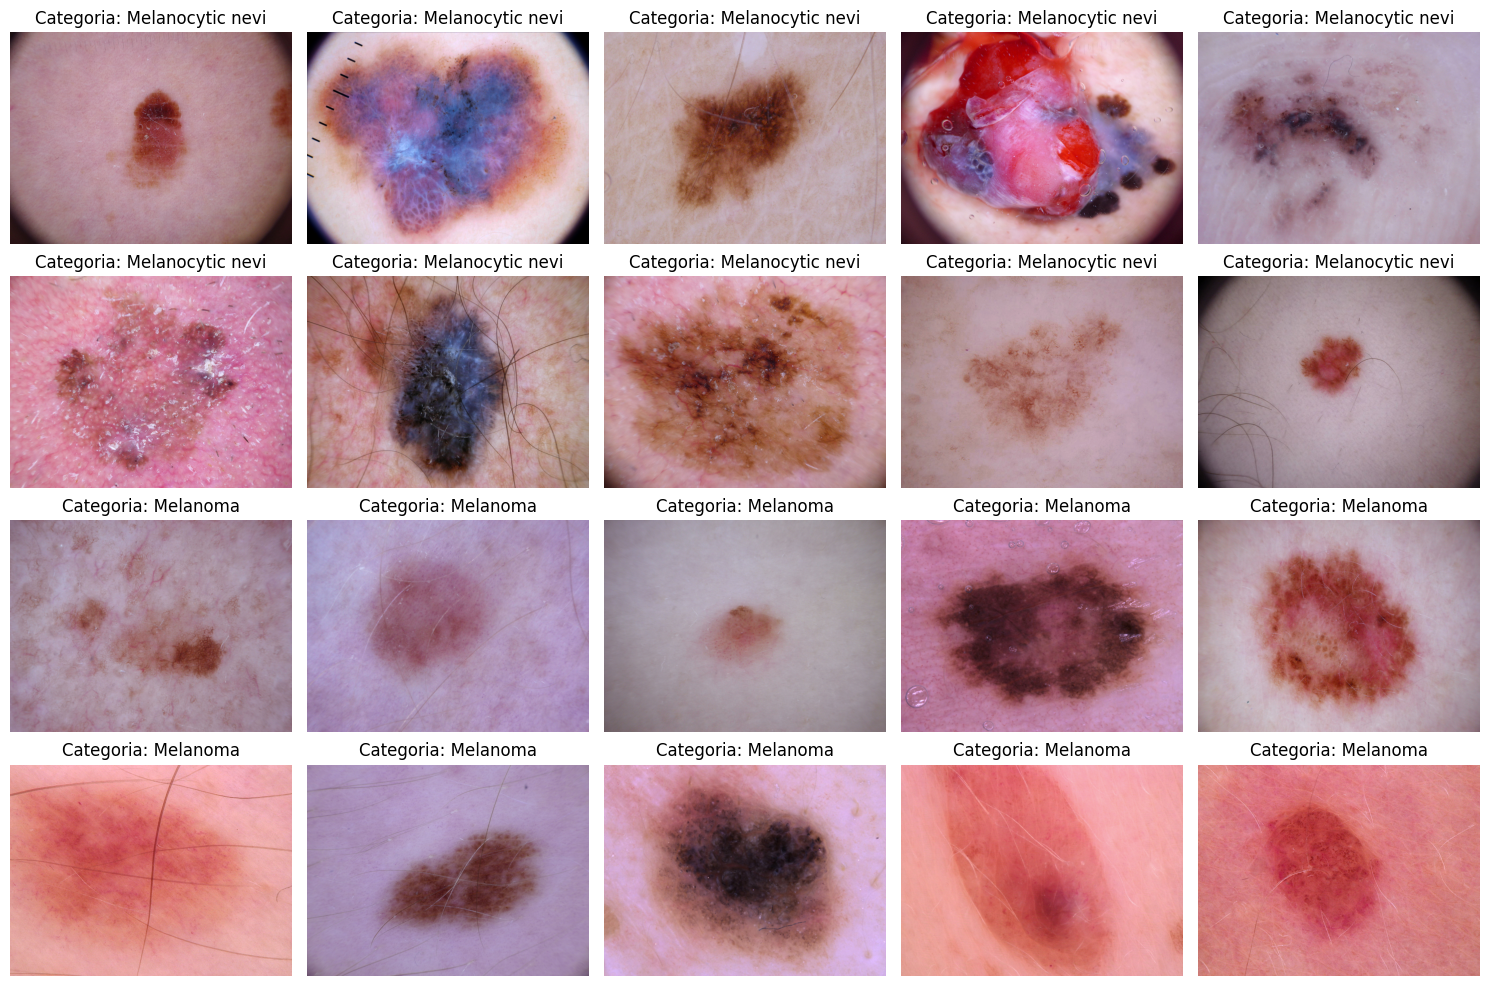

In [37]:
images_per_category = {0: 10} 
for i in range(1, 2):
    images_per_category[i] = 10

image_sample = []
image_sample_category = []

for category in range(2):
    category_dir = os.path.join(train_images_dir, str(category))
    
    if os.path.isdir(category_dir):
        images_paths = [image.path for image in os.scandir(category_dir)]
        
        selected_images = random.sample(images_paths, min(images_per_category[category], len(images_paths)))
        
        for image_path in selected_images:
            image_data = cv2.imread(image_path)[:,:,::-1]
            image_sample.append(image_data)
            image_sample_category.append(label_dict[category])

print(f"Total de muestras: {len(image_sample)}")

plt.figure(figsize=(15, 10))
for num in range(0, len(image_sample)):
    plt.subplot(4, 5, num + 1)
    plt.axis(False)
    
    category_name = lesion_type_dict[image_sample_category[num]]
    
    plt.title(f"Categoria: {category_name}")
    plt.imshow(image_sample[num])

plt.tight_layout()
plt.show()

In [38]:
img_size = 250
batch_size = 32
generator = ImageDataGenerator(zoom_range = 0.3,
                               rotation_range = 90,
                               horizontal_flip = True,
                               vertical_flip = True,
                               validation_split = 0.1,)

augmented_train_data = generator.flow_from_directory(
                            train_images_dir,
                            target_size = (img_size, img_size),
                            batch_size = batch_size,
                            subset = "training")

unaugmented_validation_data = generator.flow_from_directory(
                            train_images_dir,
                            target_size = (img_size, img_size),
                            batch_size = 32,
                            subset = "validation")

unaugmented_test_data = image_dataset_from_directory(
                            test_images_dir,
                            image_size = (img_size, img_size),
                            batch_size = batch_size)

Found 4503 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 1251 files belonging to 2 classes.


In [46]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(250, 250, 3))

for layer in resnet_model.layers:
    layer.trainable = False
model = Sequential()
model.add(resnet_model)

model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size = (3,3), input_shape= (250, 250, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size = (2,2)))

model.add(Conv2D(32, kernel_size = (3,3)))
model.add(Activation("relu"))

model.add(Flatten())
model.add(Dense(64))
model.add(Activation("relu"))

model.add(Flatten())
model.add(Dense(32))
model.add(Activation("relu"))

model.add(Dense(2))
model.add(Activation("softmax"))

callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.keras', save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=3)
]

model.compile(
    loss = "categorical_crossentropy",
    optimizer = "adam",
    metrics = ["accuracy"],
)

history = model.fit(
    augmented_train_data,
    validation_data=unaugmented_validation_data,
    epochs=100,
    verbose = 1,
    callbacks=callbacks
)

Epoch 1/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1253s 9s/step - accuracy: 0.8535 - loss: 0.3890 - val_accuracy: 0.8960 - val_loss: 0.2443 - learning_rate: 0.0010
Epoch 2/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1099s 8s/step - accuracy: 0.8827 - loss: 0.2699 - val_accuracy: 0.9000 - val_loss: 0.2345 - learning_rate: 0.0010
Epoch 3/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1130s 8s/step - accuracy: 0.9008 - loss: 0.2485 - val_accuracy: 0.8980 - val_loss: 0.2095 - learning_rate: 0.0010
Epoch 4/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1085s 8s/step - accuracy: 0.8937 - loss: 0.2472 - val_accuracy: 0.9040 - val_loss: 0.2177 - learning_rate: 0.0010
Epoch 5/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1124s 8s/step - accuracy: 0.9106 - loss: 0.2252 - val_accuracy: 0.9100 - val_loss: 0.2169 - learning_rate: 0.0010
Epoch 6/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1103s 8s/step - accuracy: 0.9109 - loss: 0.2210 - val_accuracy: 0.9200 - val_loss: 0.2292 - learning_rate: 0.0010
Epoch 7/100
141/141 ━━━━━━━━━━━━━━━━━━━━ 1126s 8s/step - accuracy: 0.9

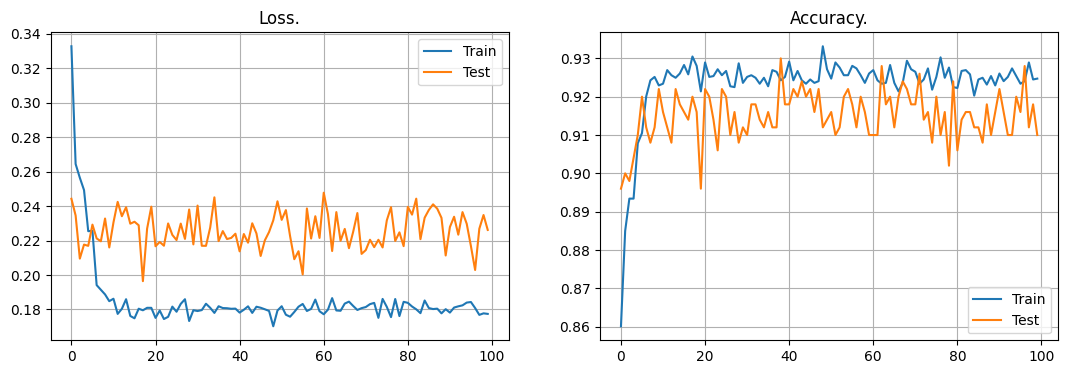

In [47]:
metrics = history.history

train_loss = metrics["loss"]
train_accuracy = metrics["accuracy"]

test_loss = metrics["val_loss"]
test_accuracy = metrics["val_accuracy"]

# Visualizing metrics
plt.figure(figsize = (13,4))
plt.subplot(1,2,1)
plt.title("Loss.")
plt.plot(train_loss, label = "Train")
plt.plot(test_loss, label = "Test")
plt.grid(True)
plt.legend(loc = "best")

plt.subplot(1,2,2)
plt.title("Accuracy.")
plt.plot(train_accuracy, label = "Train")
plt.plot(test_accuracy, label = "Test")
plt.grid(True)
plt.legend(loc = "best")

In [48]:
result = model.predict(unaugmented_test_data)

40/40 ━━━━━━━━━━━━━━━━━━━━ 318s 7s/step


40/40 ━━━━━━━━━━━━━━━━━━━━ 529s 9s/step


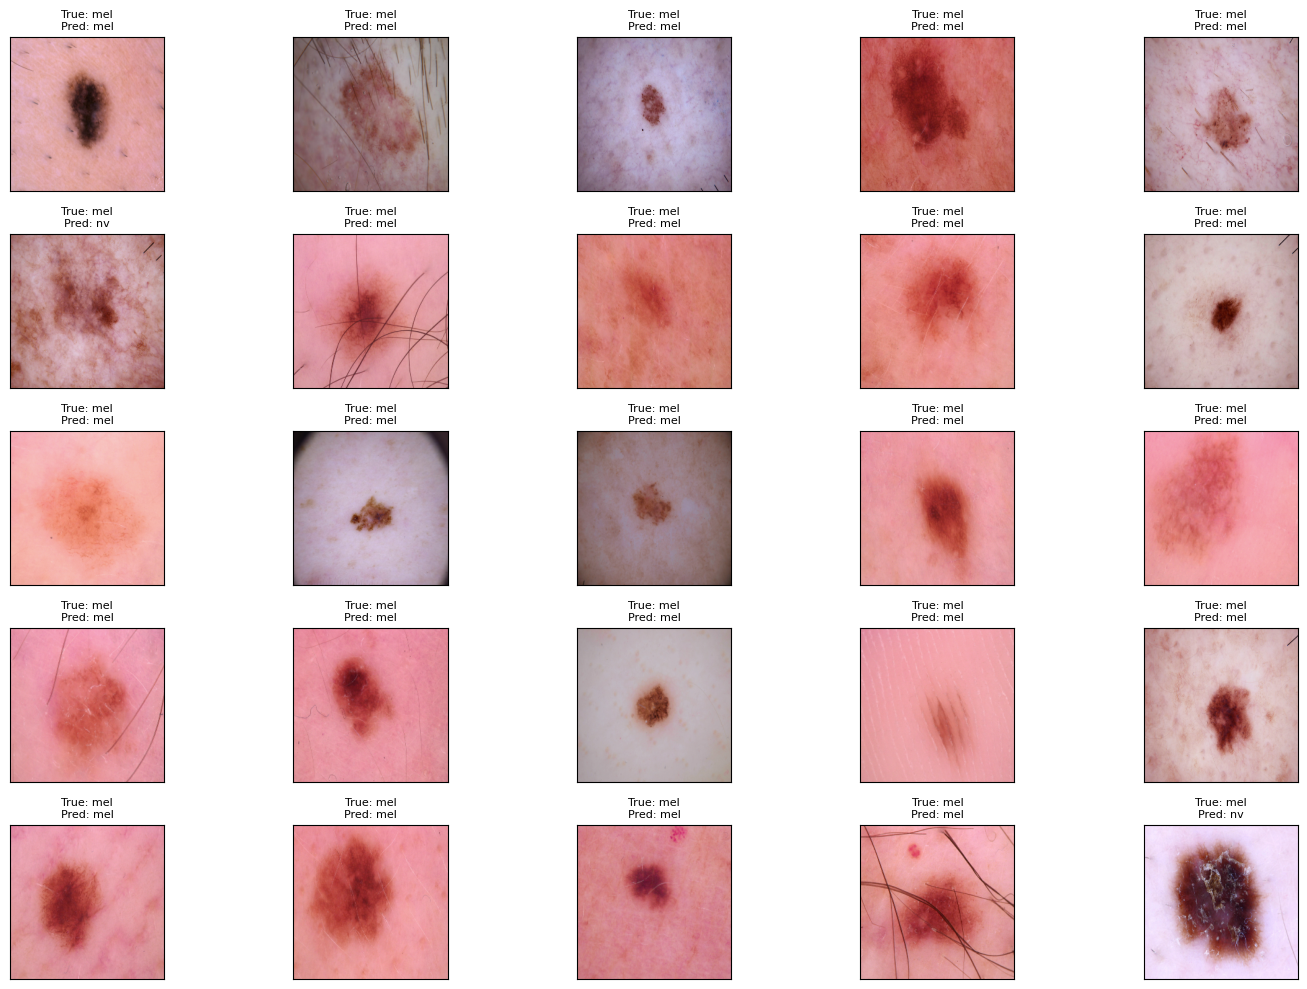

In [49]:
X_test = []
true_class = []
for images, labels in unaugmented_test_data.take(-1):
    for i in range(images.shape[0]):
        X_test.append(images[i].numpy())
        true_class.append(labels[i].numpy())

X_test = np.array(X_test)
true_class = np.array(true_class)

result = model.predict(X_test)
predicted_class = [predicted_label.argmax() for predicted_label in result]

label_dict = label_dict = {
    1: 'mel',
    0: 'nv'
}

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma'
}

def plot_images(images, true_labels, predicted_labels):
    plt.figure(figsize=(15, 10))
    for i in range(len(images)):
        plt.subplot(5, 5, i+1)
        img = images[i]
        if img.max() > 1:
            img = img / 255.0
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        true_label = label_dict[true_labels[i]]
        predicted_label = label_dict[predicted_labels[i]]
        plt.title(f"True: {true_label}\nPred: {predicted_label}", fontsize=8)
        if i == 24:
            break
    plt.tight_layout()
    plt.show()
    
plot_images(X_test, true_class, predicted_class)

Text(0.5, 23.52222222222222, 'Predicted Class')

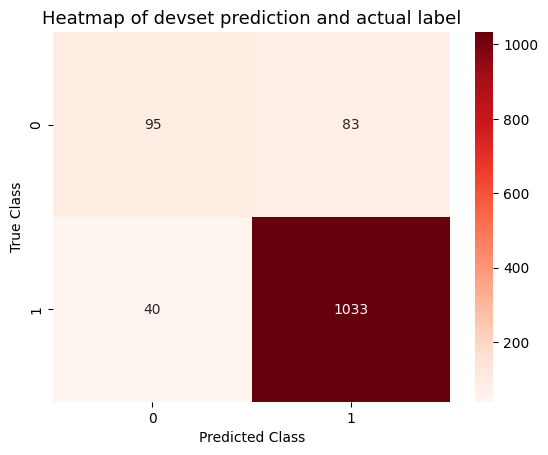

In [52]:
plt.title("Heatmap of devset prediction and actual label", fontsize = 13)
cm = confusion_matrix(true_class, predicted_class)
sns.heatmap(cm, cmap = "Reds", annot = True, fmt = "d")
plt.ylabel("True Class")
plt.xlabel("Predicted Class")
     

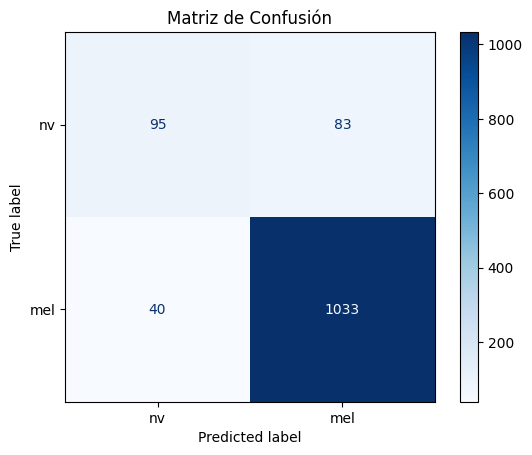

In [53]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Generar la matriz de confusión
cm = confusion_matrix(true_class, predicted_class)

# Visualizar la matriz de confusión
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[label_dict[0], label_dict[1]])
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Matriz de Confusión")
plt.show()

In [55]:
report = classification_report(true_class, predicted_class)
print(report)

              precision    recall  f1-score   support

           0       0.70      0.53      0.61       178
           1       0.93      0.96      0.94      1073

    accuracy                           0.90      1251
   macro avg       0.81      0.75      0.78      1251
weighted avg       0.89      0.90      0.90      1251

